In [1]:
from custom_network import Config, CustomDataModule, Custom_Network, LightningModel
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np


# Function to plot the confusion matrix
def plot_confusion_matrix(matrix, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap='Blues')

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="black")

    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    fig.tight_layout()
    plt.show()

In [2]:
# Random seed
rs = 42

df = pd. read_csv('depression_data.csv')
# Drop name column
df.drop(columns='Name', inplace=True)

# Identify categorical columns (object dtype)
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Remove redundant columns
no_columns = [col for col in df_encoded.columns.tolist() if col.endswith('_No')]
df_reduced = df_encoded.drop(columns=no_columns)

# Normalize the Age and Number of Children columns
df_reduced['Age'] = df_reduced['Age'] / 100
df_reduced['Number of Children'] = df_reduced['Number of Children'] / 4

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data's Income column
scaler.fit(df_reduced[['Income']])

# Transform the Income column in both training and test sets
df_reduced['Income'] = scaler.transform(df_reduced[['Income']])
df_reduced['Income'] = scaler.transform(df_reduced[['Income']])

df_reduced.head()


,Age,Number of Children,Income,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education Level_Associate Degree,Education Level_Bachelor's Degree,Education Level_High School,...,Dietary Habits_Healthy,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Patterns_Fair,Sleep Patterns_Good,Sleep Patterns_Poor,History of Mental Illness_Yes,History of Substance Abuse_Yes,Family History of Depression_Yes,Chronic Medical Conditions_Yes
0,0.31,0.50,-1.247101,0,1,0,0,0,1,0,...,0,1,0,1,0,0,1,0,1,1
1,0.55,0.25,-1.247091,0,1,0,0,0,0,1,...,0,0,1,1,0,0,1,0,0,1
2,0.78,0.25,-1.247041,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,0.58,0.75,-1.247111,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0.18,0.00,-1.247112,0,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,1,1


In [3]:
# Define X and y
X = df_reduced.drop(columns=['History of Mental Illness_Yes'])
y = df_reduced['History of Mental Illness_Yes']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 331014 samples
Test set size: 82754 samples


In [4]:
data_module = CustomDataModule(X_train, y_train, X_test, y_test, n_workers=15, batch_size=131072)

pytorch_model = Custom_Network(config=Config(num_blocks=2, n_embd=128, bias=True,dropout=0.1))

lightning_model = LightningModel(model=pytorch_model, learning_rate=0.0005)

trainer = pl.Trainer(max_epochs=20, accelerator="gpu", devices="auto", deterministic=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=lightning_model, datamodule=data_module)

In [6]:
trainer.test(ckpt_path= 'best', datamodule=data_module)

Restoring states from the checkpoint path at /home/alejandro/Documents/Portfolio/Lead-Data-Scientist-Test/lightning_logs/version_31/checkpoints/epoch=19-step=60.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/alejandro/Documents/Portfolio/Lead-Data-Scientist-Test/lightning_logs/version_31/checkpoints/epoch=19-step=60.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

/home/alejandro/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: TorchMetricsUserWarning: You are trying to use a metric in deterministic mode on GPU that uses `torch.cumsum`, which is currently not supported. The tensor will be copied to the CPU memory to compute it and then copied back to GPU. Expect some slowdowns.
  warnings.warn(*args, **kwargs)  # noqa: B028


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5111172795295715     │
│         test_auc          │    0.5625492930412292     │
│         test_prec         │    0.7185376286506653     │
│         test_rec          │    0.3514070212841034     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5111172795295715,
  'test_auc': 0.5625492930412292,
  'test_prec': 0.7185376286506653,
  'test_rec': 0.3514070212841034}]

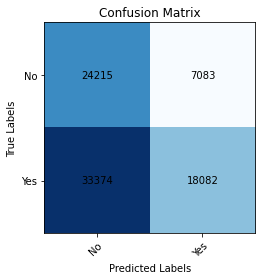

In [7]:
plot_confusion_matrix(lightning_model.conf_mtx.compute().numpy(), ['No', 'Yes'])